# Tutorial: Climate Networks

The objective of this tutorial is to introduce climate networks, and to explain and illustrate their application with the `pyunicorn` package. First some theoretical background for understanding general climate networks will be given, and then some methods provided by `pyunicorn.climate.ClimateNetwork` will be illustrated. An introduction and application of coupled climate networks will follow. For a detailed discussion and further references, please consult __[Donges et al. (2015)](https://aip.scitation.org/doi/10.1063/1.4934554)__, on which this tutorial is based. 

## Introduction

_Climate networks (CN)_ are a way to apply complex network theory to the climate system, by assuming that each node represents a varying dynamical system. Of interest is then the collective behaviour of these interacting dynamical systems and the structure of the resulting network. This approach was first introduced by __[Tsonis and Roebber (2004)](https://www.sciencedirect.com/science/article/abs/pii/S0378437103009646)__.

CN analysis is a versatile approach for investigating climatological data, and it can be used as a complementary method to classical techniques from multivariate statistics. The approach allows for the analysis of single fields of climatological time series, e.g., surface air temperature observed on a grid, or even two or more fields. It has been successfully applied in many cases, for example to dynamics and predictability of the El Niño Phenomenon (__[Radebach et al., 2013](https://arxiv.org/abs/1310.5494)__).

## Theory of Climate Networks (CNs)

CNs are a typical application of _functional networks_, which allow to study the dynamical relationships between subsystems of a high-dimensional complex system by constructing networks from it. `pyunicorn` provides classes for the construction and analysis of such networks, representing the statistical interdependency structure within and between fields of time series using various similarity measures.

### Coupling Analysis

CNs represent strong statistical interrelationships between time series of climatological fields. These statistical interrelationships can be estimated with methods from the `funcnet.CouplingAnalysis` class in terms of matrices of _statistical similarities_ $\textbf{S}$, such as the _(lagged) classical linear Pearson product-moment correlation coefficient_ (CC). The CC of two zero-mean time series variables $X,Y$, as implemented in `funcnet.CouplingAnalysis.cross_correlation()`, is given by 
$$\rho_{XY}(\tau)=\frac{\langle X_{t-\tau}, Y_t \rangle}{\sigma_X \sigma_Y}\,,$$
which depends on the covariance $\langle X_{t-\tau}, Y_t \rangle$ and the standard deviations $\sigma_X, \sigma_Y$. Lags $\tau > 0$ correspond to the linear association of past values of $X$ with $Y$, and vice versa for $\tau < 0$. 

### Similarity Measures for CNs

By thresholding the matrix of a statistical similarity measure $\textbf{S}$, the interrelationships between time series of climate networks can be reconstructed:
$$A_{pq} = \Theta(S_{pq}-\beta)\quad \text{ if } p \neq q; \qquad 0\quad\text{otherwise}\,,$$
where $\Theta$ is the Heaviside function, $\beta$ denotes a threshold parameter, and $A_{pp} = 0$ for all nodes $p$ to exclude self-loops. A CN that is reconstructed using the Pearson CC from above is called a _Pearson correlation CN_.

## Constructing CNs

Having established some basic theoretic background, we will now use `pyunicorn` to construct a CN. We start by importing the required packages, by downloading an example __[NOAA dataset](https://psl.noaa.gov/repository/entry/show?entryid=synth%3Ae570c8f9-ec09-4e89-93b4-babd5651e7a9%3AL25jZXAucmVhbmFseXNpcy5kZXJpdmVkL3N1cmZhY2UvYWlyLm1vbi5tZWFuLm5j)__, and by specifying some metadata for it.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from pyunicorn import climate

In [3]:
DATA_NAME = "air.mon.mean.nc"
DATA_URL = f"https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/surface/{DATA_NAME}"
DATA_FILE = f"./data/{DATA_NAME}"
![ -f {DATA_FILE} ] || wget -O {DATA_FILE} -nv --show-progress "{DATA_URL}"

./data/air.mon.mean 100%[===================>]  28.12M  2.25MB/s    in 88s     
2025-12-12 15:53:44 URL:https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/surface/air.mon.mean.nc [29489350/29489350] -> "./data/air.mon.mean.nc" [1]


In [4]:
DATA_FILENAME = "./data/air.mon.mean.nc"
#  Indicate data source (optional)
DATA_SOURCE = "ncep_ncar_reanalysis"
#  Type of data file ("NetCDF" indicates a NetCDF file with data on a regular
#  lat-lon grid, "iNetCDF" allows for arbitrary grids - > see documentation).
FILE_TYPE = "NetCDF"
#  Name of observable in NetCDF file ("air" indicates surface air temperature
#  in NCEP/NCAR reanalysis data)
OBSERVABLE_NAME = "air"
#  Select a region in time and space from the data (here the whole dataset)
WINDOW = {"time_min": 0., "time_max": 0., "lat_min": 0, "lon_min": 0,
          "lat_max": 30, "lon_max": 0}
#  Indicate the length of the annual cycle in the data (e.g., 12 for monthly
#  data). This is used for calculating climatological anomaly values.
TIME_CYCLE = 12

Now we set some parameters for the CN construction, the first being the threshold $\beta$ from above, and create a `ClimateData` object containing our data.

In [5]:
#  For setting fixed threshold
THRESHOLD = 0.5
#  For setting fixed link density
LINK_DENSITY = 0.005
#  Indicates whether to use only data from winter months (DJF) for calculating
#  correlations
WINTER_ONLY = False

data = climate.ClimateData.Load(
    file_name=DATA_FILENAME, observable_name=OBSERVABLE_NAME,
    data_source=DATA_SOURCE, file_type=FILE_TYPE,
    window=WINDOW, time_cycle=TIME_CYCLE)
print(data)

Reading NetCDF File and converting data to NumPy array...
Global attributes:
description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
platform: Model
Conventions: COARDS
NCO: 20121012
history: Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc
Thu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc
Mon Jul  5 23:47:18 1999: ncrcat ./air.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/air.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Mon Oct 23 21:04:20 1995 from air.sfc.gauss.85.nc
created 95/03/13 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
title: monthly mean air.sig995 from the NCEP Reanalysis
dataset_title: NCEP-NCAR Reanalysis 1
References: http://www.psl.noaa.gov/data/gridded/da

Next, we construct a CN based on the Pearson CC, without lag and with fixed threshold. Alternatively, several other similarity measures and construction mechanisms may be used as well.

In [6]:
net = climate.TsonisClimateNetwork(
    data, threshold=THRESHOLD, winter_only=WINTER_ONLY)

Generating a Tsonis climate network...
Calculating daily (monthly) anomaly values...
Calculating correlation matrix at zero lag from anomaly values...
Extracting network adjacency matrix by thresholding...
Setting area weights according to type surface ...
Setting area weights according to type surface ...


In [6]:
#  Create a climate network based on Pearson correlation without lag and with
#  fixed link density
# net = climate.TsonisClimateNetwork(
#     data, link_density=LINK_DENSITY, winter_only=WINTER_ONLY)

In [7]:
#  Create a climate network based on Spearman's rank order correlation without
#  lag and with fixed threshold
# net = climate.SpearmanClimateNetwork(
#     data, threshold=THRESHOLD, winter_only=WINTER_ONLY)

In [8]:
#  Create a climate network based on mutual information without lag and with
#  fixed threshold
# net = climate.MutualInfoClimateNetwork(
#     data, threshold=THRESHOLD, winter_only=WINTER_ONLY)

We finish by calculating some basic network measures for the resulting CN, optionally saving them to text files.

In [7]:
print("Link density:", net.link_density)

degree = net.degree()
closeness = net.closeness()
betweenness = net.betweenness()
clustering = net.local_clustering()
ald = net.average_link_distance()
mld = net.max_link_distance()

#  Save the grid (mainly vertex coordinates) to text files
#data.grid.save_txt(filename="grid.txt")
#  Save the degree sequence. Other measures may be saved similarly.
#np.savetxt("degree.txt", degree)

Link density: 0.028533654023682083
Calculating closeness...
Calculating node betweenness...
Calculating local clustering coefficients...
Calculating average link distance...
Calculating angular great circle distance...
Calculating maximum link distance...


## Plotting CNs

`pyunicorn` provides a basic plotting feature based on the __[cartopy](https://scitools.org.uk/cartopy/docs/latest/)__ and `matplotlib` packages, which can be used to have a first look at the generated data. We start by initializing a `MapPlot` object:

In [8]:
# create a Cartopy plot instance called map_plot
# from the data with title DATA_SOURCE
map_plot = climate.MapPlot(data.grid, DATA_SOURCE)

With `MapPlot.plot()`, we can now plot some of our previously calculated measures on the given grid.

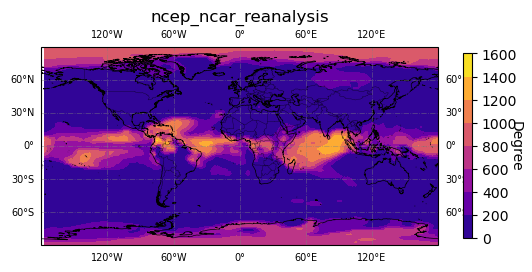

In [9]:
# plot degree
map_plot.plot(degree, "Degree")

# add matplotlib.pyplot or cartopy commands to customize figure
plt.set_cmap('plasma')
# optionally save figure
#plt.savefig('degree.png')

Try plotting more measures if you like.

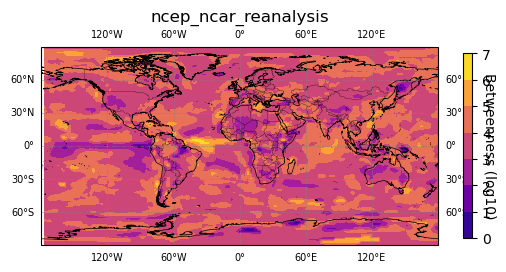

In [10]:
# plot betwenness
map_plot.plot(np.log10(betweenness + 1), "Betweenness (log10)")

# add matplotlib.pyplot or cartopy commands to customize figure
plt.set_cmap('plasma')
# optionally save figure
#plt.savefig('degree.png')